# Total costs plot for 2% discount rate

/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_65305/3585899202.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_65305/3585899202.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)


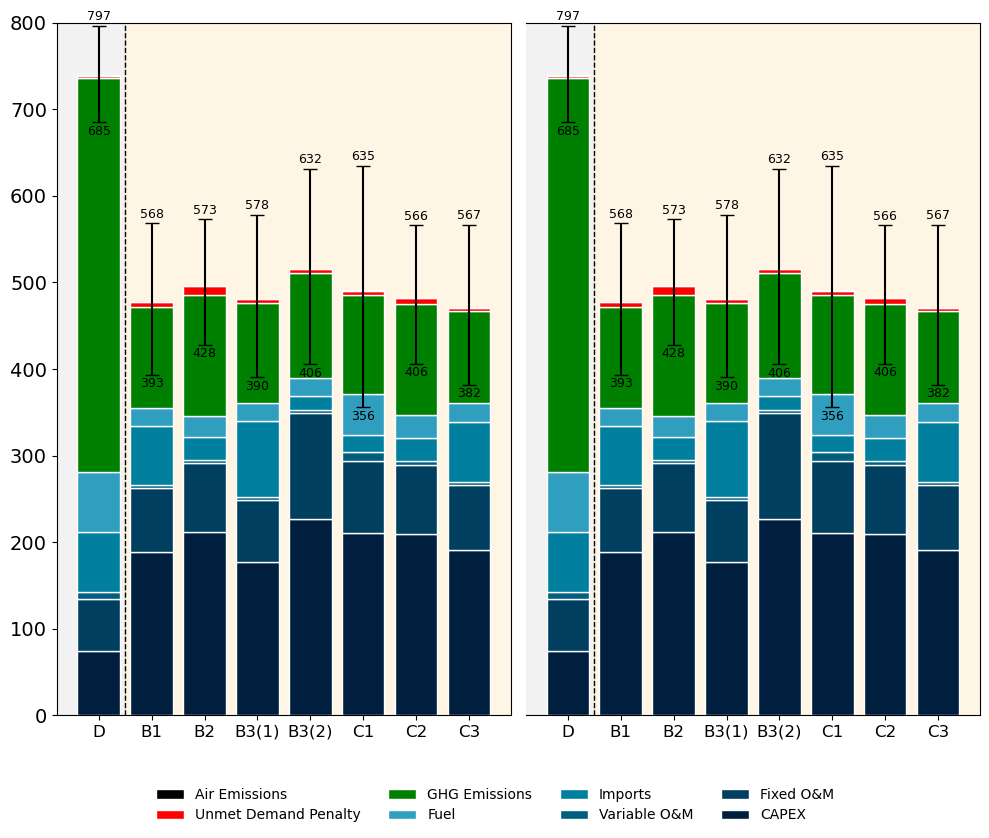

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load CSV for each dataset ---
csv_path_dr2 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/discount rate 2 percent/All_Costs.csv"
combined_ranges_dr2 = pd.read_csv(csv_path_dr2)

csv_path_dr1_5 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/discount rate 1.5 percent/All_Costs.csv"
combined_ranges_dr1_5 = pd.read_csv(csv_path_dr1_5)
# Define a small helper to clean each DataFrame

def clean_cost_df(df):
    # keep only rows with a non-null Pathway that is not 'A'
    mask = df['Pathway'].notna() & (df['Pathway'] != 'A')
    df = df[mask].copy()
    # ensure Cost_bUSD is numeric and fill NaNs with 0
    df['Cost_bUSD'] = pd.to_numeric(df['Cost_bUSD'], errors='coerce').fillna(0)
    return df
# Apply to both
combined_ranges_dr2 = clean_cost_df(combined_ranges_dr2)
combined_ranges_dr1_5 = clean_cost_df(combined_ranges_dr1_5)
def format_cost(x):
    """
    Helper function to format numbers (floats) with commas and no decimals.
    """
    return f"{x:,.0f}"

# --- Define stacking order and colors ---
stacking_order = [
    'CAPEX', 'Fixed O&M', 'Variable O&M', 'Imports', 
    'Fuel', 'GHG Emissions', 'Unmet Demand Penalty', 'Air Emissions'
]

custom_colors = {
    'Air Emissions': 'black',
    'Unmet Demand Penalty': 'red',
    'GHG Emissions': 'green',
    'Fuel': '#309fbf',
    'Imports': '#007f9f',
    'Variable O&M': '#005f7f',
    'Fixed O&M': '#003f5f',
    'CAPEX': '#001f3f'
}
colors = [custom_colors[c] for c in stacking_order]

def plot_dataset(data, ax, title=None, show_rectangles=True):
    """
    Plots stacked bars + error bars for a single dataset on a given Axes object.
    """
    # 1) Aggregate costs by Pathway & Statistic
    total_costs = (
        data
          .loc[data['Cost_Type'] == 'Total_Costs', 
               ['Pathway','Statistic','Cost_bUSD']]
          .rename(columns={'Cost_bUSD':'Total_Cost_bUSD'})
          .reset_index(drop=True)
    )
    mean_costs = total_costs[total_costs['Statistic'] == 'mean']
    min_costs  = total_costs[total_costs['Statistic'] == 'min']
    max_costs  = total_costs[total_costs['Statistic'] == 'max']

    # 2) Pivot data (only the 'mean' rows) for stacked bar
    stacked_data = (
        data[data['Statistic'] == 'mean']
        .pivot(index='Pathway', columns='Cost_Type', values='Cost_bUSD')
        .fillna(0)
    )
    # Reorder columns in the stacking order
    stacked_data = stacked_data[stacking_order]

    # Optionally reorder rows so certain pathways appear first
    if "D" in stacked_data.index:
        stacked_data = stacked_data.loc[["D"] + [x for x in stacked_data.index if x != "D"]]
    if "A" in stacked_data.index:
        stacked_data = stacked_data.loc[["A"] + [x for x in stacked_data.index if x != "A"]]

    # 3) Plot stacked bars
    for i, col in enumerate(stacked_data.columns):
        bottom_vals = stacked_data.iloc[:, :i].sum(axis=1) if i > 0 else 0
        ax.bar(
            stacked_data.index,
            stacked_data[col],
            bottom=bottom_vals,
            label=col,
            color=colors[i],
            edgecolor="white"
        )

    # 4) Add vertical error bars + text for min / max
    offset = 3
    for pathway in stacked_data.index:
        ymin = min_costs.loc[min_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        ymax = max_costs.loc[max_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        mean_val = mean_costs.loc[mean_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]

        # Plot error bars
        ax.errorbar(
            x=pathway,
            y=mean_val,
            yerr=[[mean_val - ymin], [ymax - mean_val]],
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=5
        )
        # Label max value (above the top)
        ax.text(
            x=pathway,
            y=ymax + offset,
            s=format_cost(ymax),
            ha='center',
            va='bottom',
            fontsize=9
        )
        # Label min value (below the bottom)
        ax.text(
            x=pathway,
            y=ymin - offset,
            s=format_cost(ymin),
            ha='center',
            va='top',
            fontsize=9
        )

    # 5) Optionally add rectangles & text
    if show_rectangles:
        # Add dashed divider line
        ax.axvline(x=.5, color="black", linewidth=1, linestyle="--")
        ax.set_ylim(0, 800)

        # We draw two large translucent rectangles
        rect_width = 2
        rect_height = 800
        rect_x = -0.5
        rect_y = 0

        # 1) Gray rectangle for "no retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x - 1, rect_y),
                rect_width,
                rect_height,
                color="gray",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # 2) Orange rectangle for "With planned retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x + 1, rect_y),
                rect_width + 6,
                rect_height,
                color="orange",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )

    # 6) Title and style
    if title:
        ax.set_title(title, fontsize=14, pad=15)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # --- Rename x-axis tick labels for B1 and B1-A ---
    mapping = {"B3(1)": "B3(1)", "B3(2)": "B3(2)"}
    new_labels = [mapping.get(item, item) for item in stacked_data.index]
    ax.set_xticklabels(new_labels, fontsize=12)

# -------------------------------------------------------------------------
# Create subplots with a shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# Plot DR3 on the left
plot_dataset(combined_ranges_dr2, axes[0], show_rectangles=True)

# Plot DR7 on the right
plot_dataset(combined_ranges_dr1_5, axes[1], show_rectangles=True)

# Remove y-axis ticks & spine from right subplot to achieve a "single y-axis" look
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axes[1].spines['left'].set_visible(False)

# Tighten layout / reduce the gap between subplots
plt.subplots_adjust(wspace=0)

# --- Create a single legend for the figure ---
handles, labels = axes[0].get_legend_handles_labels()
# Reverse so the legend order matches the stack order top-to-bottom
fig.legend(
    handles[::-1],
    labels[::-1],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # place at the bottom center
    ncol=4,                       # number of columns in the legend
    frameon=False,
    framealpha=0.9,
    fancybox=True
)

# Adjust layout so the legend at bottom is not cut off
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig('Total_Costs_Comparison.svg', dpi=300, bbox_inches='tight')
plt.show()


# B1 cost different plot for 2% discount rate

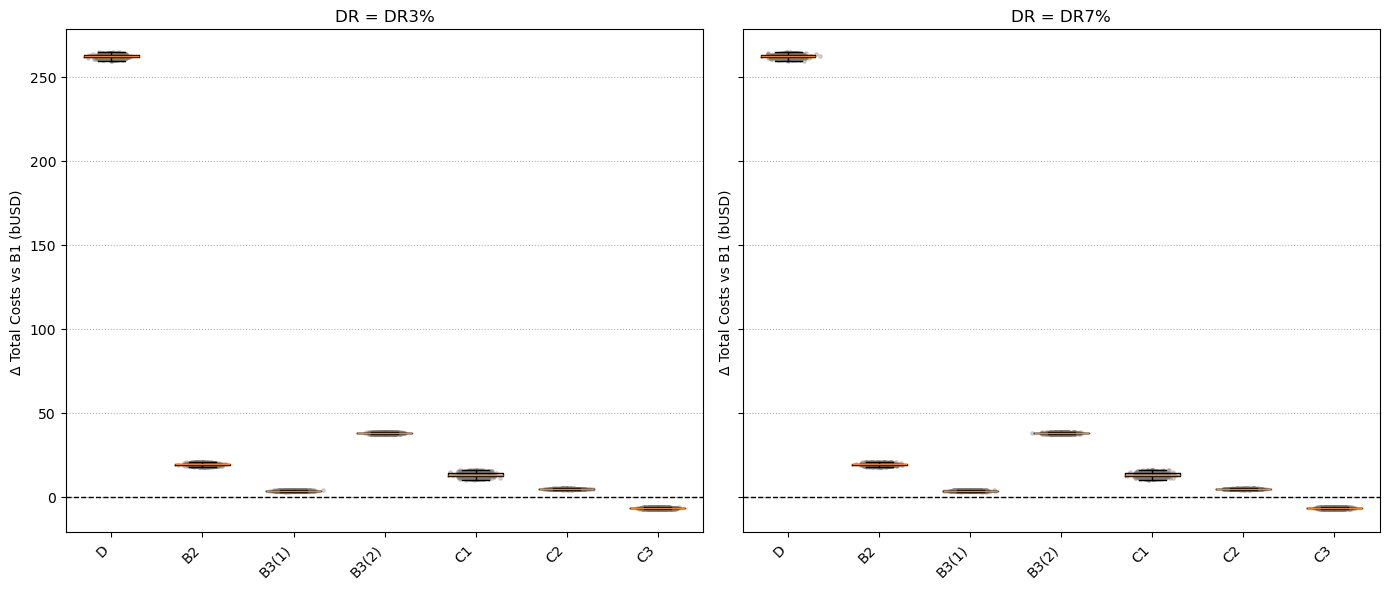

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- file locations ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
files = {
    'DR3': os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv"),
    'DR7': os.path.join(base_dir, "discount rate 1.5 percent/All_Costs_per_Simulation.csv")
}

def load_and_filter(path):
    df = pd.read_csv(path)
    # assume B1_Diff_mean_bUSD is already in your CSV
    return df[~df['Pathway'].isin(['A','B1'])]

def remove_outliers(df, col='B1_Diff_mean_bUSD', k=1.5):
    # compute per-pathway Q1, Q3, and IQR
    q1 = df.groupby('Pathway')[col].transform(lambda x: x.quantile(0.25))
    q3 = df.groupby('Pathway')[col].transform(lambda x: x.quantile(0.75))
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    # keep only rows within [lower, upper]
    return df[df[col].between(lower, upper)]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, (label, path) in zip(axes, files.items()):
    df = load_and_filter(path)
    df = remove_outliers(df, 'B1_Diff_mean_bUSD', k=1.5)

    pathways = sorted(df['Pathway'].unique(), key=lambda x:(x!='D', x))
    data = [df.loc[df['Pathway']==p, 'B1_Diff_mean_bUSD'].values for p in pathways]

    # boxplot without fliers
    ax.boxplot(data, widths=0.6, whis=1.5, showfliers=False)

    # jittered scatter
    for i, vals in enumerate(data, start=1):
        x = np.random.normal(i, 0.08, size=len(vals))
        ax.scatter(x, vals, alpha=0.3, s=6, color='gray')

    ax.axhline(0, linestyle='--', color='black', linewidth=1)
    ax.set_xticks(range(1, len(pathways)+1))
    ax.set_xticklabels(pathways, rotation=45, ha='right')
    ax.set_title(f'DR = {label}%')
    ax.set_ylabel('Δ Total Costs vs B1 (bUSD)')
    ax.grid(axis='y', linestyle=':')

plt.tight_layout()
plt.show()


In [4]:
for label, path in files.items():
    df = load_and_filter(path)
    
    # --- compute outlier mask exactly as in remove_outliers() ---
    col = 'B1_Diff_mean_bUSD'
    q1 = df.groupby('Pathway')[col].transform(lambda x: x.quantile(0.25))
    q3 = df.groupby('Pathway')[col].transform(lambda x: x.quantile(0.75))
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = df[col].between(lower, upper)
    
    # --- count how many got dropped per pathway ---
    outlier_counts = (
        df.assign(is_outlier=~mask)
          .groupby('Pathway')['is_outlier']
          .sum()
          .reset_index(name='n_outliers_removed')
    )
    print(f"\nDR = {label}% — outliers removed by pathway:")
    print(outlier_counts.to_string(index=False))
    
    # --- now drop them for plotting ---
    df = df[mask]
    


DR = DR3% — outliers removed by pathway:
Pathway  n_outliers_removed
     B2                   9
  B3(1)                   6
  B3(2)                   3
     C1                  13
     C2                   5
     C3                  14
      D                   9

DR = DR7% — outliers removed by pathway:
Pathway  n_outliers_removed
     B2                   9
  B3(1)                   6
  B3(2)                   3
     C1                  13
     C2                   5
     C3                  14
      D                   9


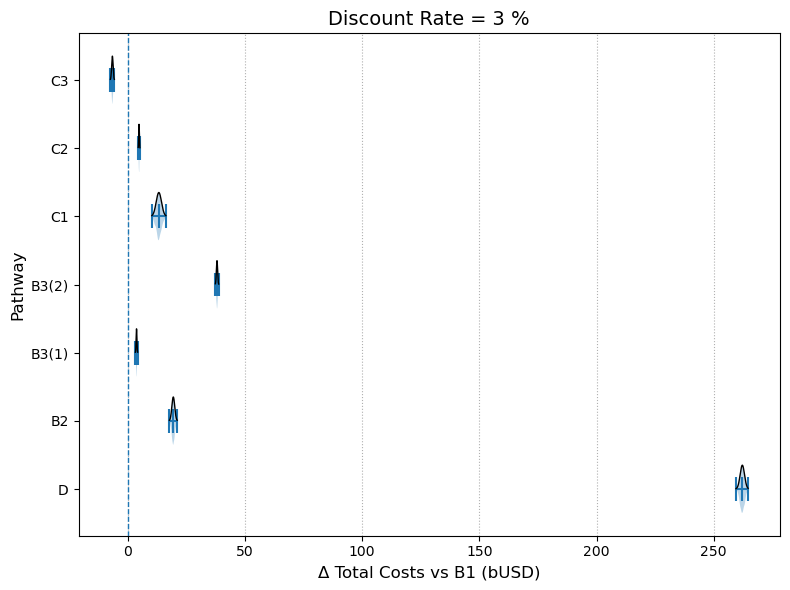

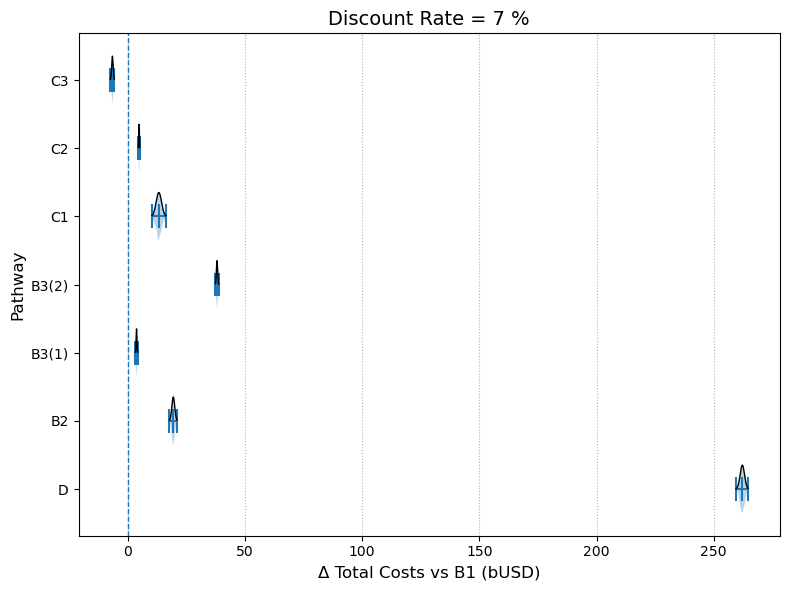

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- file locations ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
files = {
    'DR3': os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv"),
    'DR7': os.path.join(base_dir, "discount rate 1.5 percent/All_Costs_per_Simulation.csv")
}

def load_and_filter(path):
    """Load CSV and drop Pathways 'A' and 'B1'."""
    df = pd.read_csv(path)
    return df.loc[~df['Pathway'].isin(['A','B1'])].copy()

def remove_outliers(df, col='B1_Diff_mean_bUSD', k=1.5):
    """
    Remove rows where `col` is outside [Q1 - k*IQR, Q3 + k*IQR]
    computed per Pathway, using np.percentile.
    """
    # per-group Q1 and Q3
    q1 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x, 25))
    q3 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x, 75))
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return df[df[col].between(lower, upper)].copy()

for key, path in files.items():
    # 1) load & filter
    df = load_and_filter(path)
    # 2) remove outliers
    df = remove_outliers(df, col='B1_Diff_mean_bUSD', k=1.5)

    # 3) prepare data for plotting
    pathways = sorted(df['Pathway'].unique(), key=lambda x: (x!='D', x))
    data = [df.loc[df['Pathway']==p, 'B1_Diff_mean_bUSD'].values for p in pathways]

    rate = int(key.replace('DR',''))
    fig, ax = plt.subplots(figsize=(8,6))

    # 4) horizontal violins with medians
    parts = ax.violinplot(
        data,
        showmedians=True,
        widths=0.7,
        vert=False
    )

    # 5) overlay a fitted normal PDF as a "bell curve" on each violin
    for i, arr in enumerate(data, start=1):
        # fit normal distribution
        mu, sigma = norm.fit(arr)
        # x-range for PDF
        x_vals = np.linspace(arr.min(), arr.max(), 200)
        pdf = norm.pdf(x_vals, mu, sigma)
        # scale PDF so its max width is about half the violin width
        pdf = pdf / pdf.max() * 0.35
        # plot it centred on y = i
        ax.plot(x_vals, np.full_like(x_vals, i) + pdf, color='black', linewidth=1)

    # 6) zero‐line for reference
    ax.axvline(0, linestyle='--', linewidth=1)

    # 7) tidy y‐axis
    ax.set_yticks(np.arange(1, len(pathways)+1))
    ax.set_yticklabels(pathways, fontsize=10)

    # 8) labels & title
    ax.set_xlabel('Δ Total Costs vs B1 (bUSD)', fontsize=12)
    ax.set_ylabel('Pathway', fontsize=12)
    ax.set_title(f'Discount Rate = {rate} %', fontsize=14)

    # 9) grid
    ax.grid(axis='x', linestyle=':')

    plt.tight_layout()
    plt.show()


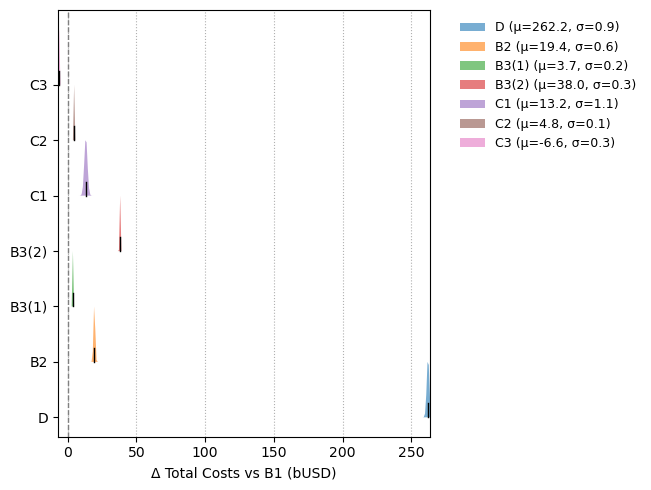

In [6]:

# --- point this at your local CSV ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- load 3% data ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3 = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df = pd.read_csv(file3)
df = df[~df['Pathway'].isin(['A','B1'])]

# remove outliers by IQR
col = 'B1_Diff_mean_bUSD'
q1 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,25))
q3 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,75))
iqr = q3 - q1
df = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# common x-grid
xmin, xmax = df[col].quantile([0.01, 0.99])
x = np.linspace(xmin, xmax, 300)

# prepare
pathways = sorted(df['Pathway'].unique(), key=lambda x:(x!='D',x))
n = len(pathways)

plt.figure(figsize=(4.5, 5))
for i, pw in enumerate(pathways):
    data = df.loc[df['Pathway']==pw, col].values

    # fit gaussian
    mu, sigma = norm.fit(data)
    y = norm.pdf(x, mu, sigma)

    # normalize height
    y = y / y.max()

    # offset for ridgeline
    y0 = i   # base level
    plt.fill_between(x, y0, y0 + y,
                     alpha=0.6,
                     label=f"{pw} (μ={mu:.1f}, σ={sigma:.1f})")

    # mark mean
    plt.plot([mu, mu], [y0, y0 + 0.25], 'k-', lw=1)

# styling
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.yticks(np.arange(n), pathways)
plt.xlim(xmin, xmax)
plt.xlabel('Δ Total Costs vs B1 (bUSD)')
#plt.title('Ridgeline of Normal-fits for 3 % Discount Rate')
plt.grid(axis='x', linestyle=':')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, frameon=False)
plt.savefig('Total_Costs_Diff.svg', dpi=300, bbox_inches='tight')
plt.show()


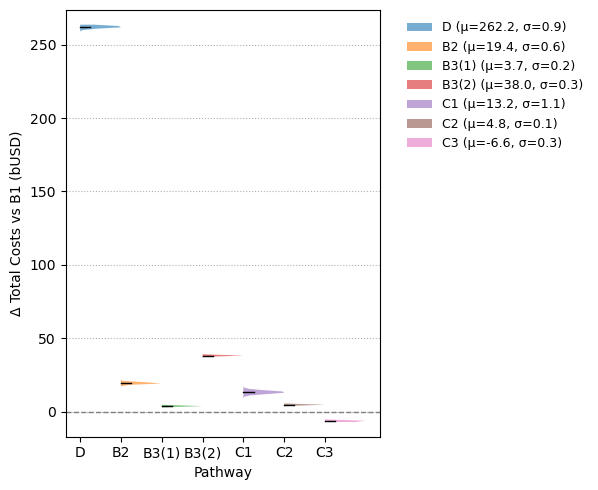

In [9]:
plt.figure(figsize=(4, 5))

for i, pw in enumerate(pathways):
    data = df.loc[df['Pathway']==pw, col].values

    # fit gaussian
    mu, sigma = norm.fit(data)
    pdf = norm.pdf(x, mu, sigma)
    pdf = pdf / pdf.max()

    # horizontal ridgeline: x-offset is i, y runs along the cost axis
    plt.fill_betweenx(
        x,                 # y-grid is your original x-grid
        i,                 # left x bound
        i + pdf,           # right x bound (offset by normalized height)
        alpha=0.6,
        label=f"{pw} (μ={mu:.1f}, σ={sigma:.1f})"
    )

    # mark mean with a short horizontal line
    plt.plot(
        [i, i + 0.25],     # x from i to i+0.25
        [mu, mu],          # y at the mean
        'k-', lw=1
    )

# styling
plt.axhline(0, color='gray', linestyle='--', lw=1)        # zero‐line across
plt.xticks(np.arange(n), pathways)                       # pathway labels along x
plt.ylim(xmin-10, xmax+10)                                      # cost range along y
plt.xlabel('Pathway')                                    
plt.ylabel('Δ Total Costs vs B1 (bUSD)')
plt.grid(axis='y', linestyle=':')                        # grid on cost axis
plt.tight_layout()
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    frameon=False
)
plt.savefig('Total_Costs_Diff.svg', dpi=300, bbox_inches='tight')
plt.show()


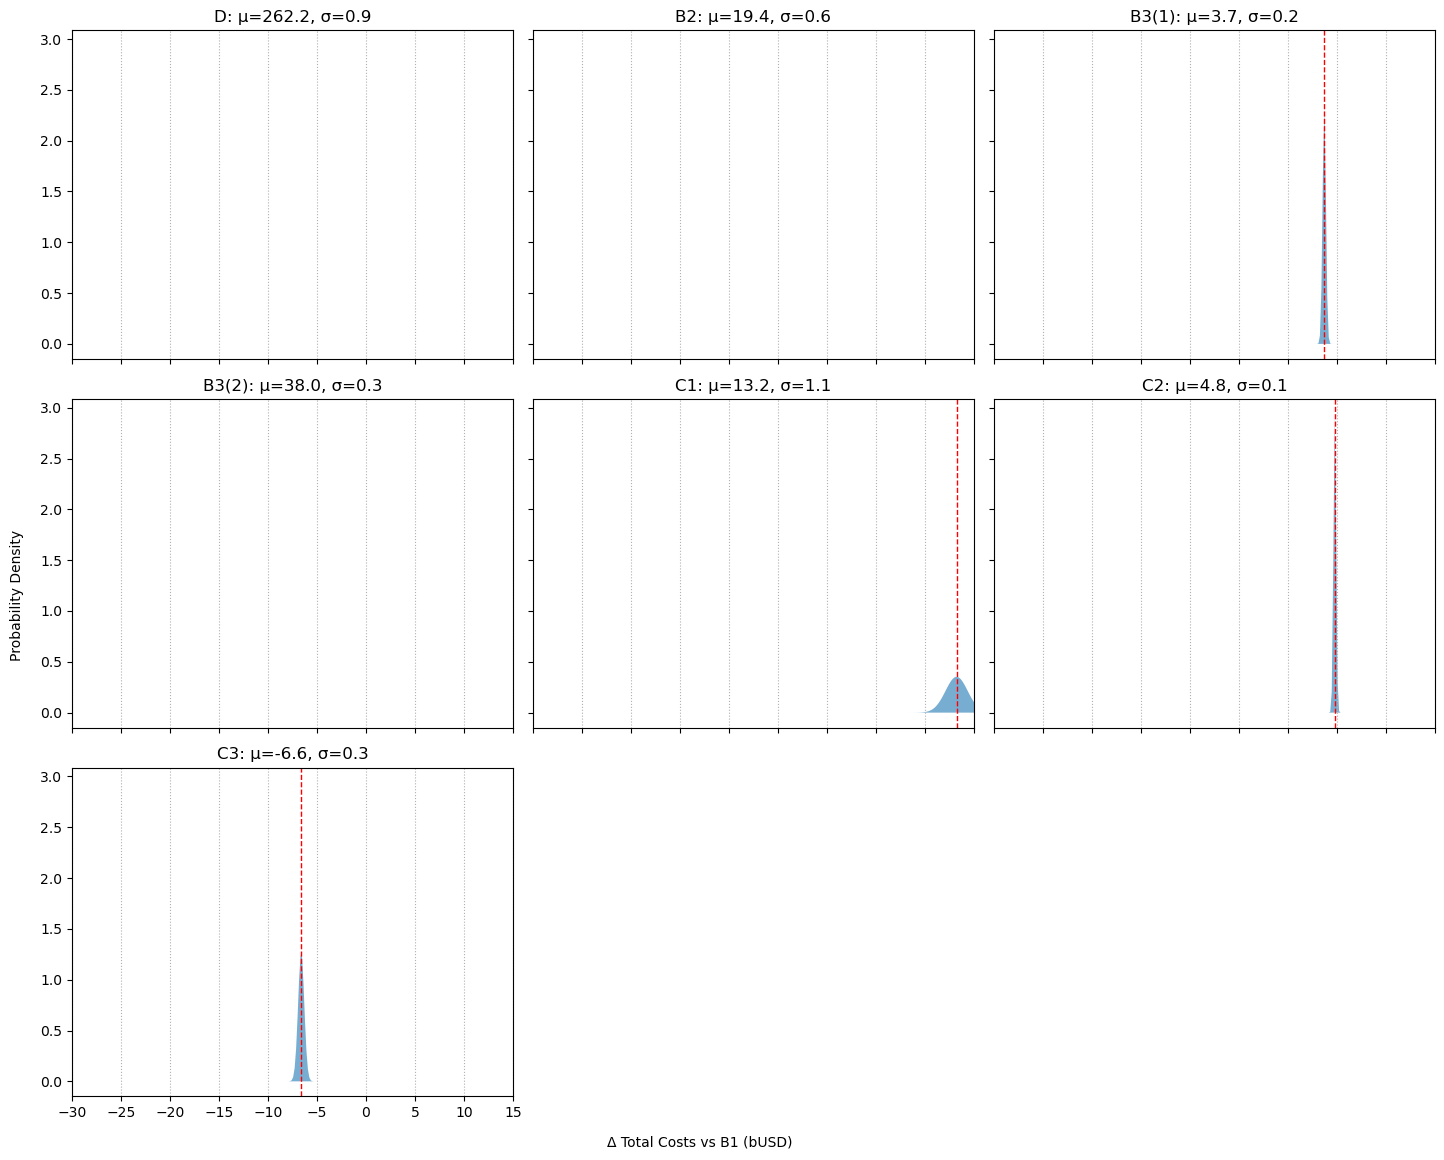

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

# --- load & prep just like before ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3 = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df = pd.read_csv(file3)
df = df[~df['Pathway'].isin(['A','B1'])]
col = 'B1_Diff_mean_bUSD'
q1 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,25))
q3 = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,75))
iqr = q3 - q1
df = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# fixed common x-grid spanning -30…15
x = np.linspace(-30, 15, 300)
pathways = sorted(df['Pathway'].unique(), key=lambda x:(x!='D',x))
n = len(pathways)

# decide grid shape
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*5, nrows*4),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, pw in zip(axes, pathways):
    data = df.loc[df['Pathway']==pw, col].values
    mu, sigma = norm.fit(data)
    y = norm.pdf(x, mu, sigma)

    # shaded PDF
    ax.fill_between(x, y, 0, alpha=0.6)

    # mean marker (keep if you like)
    ax.axvline(mu, color='red', linestyle='--', lw=1)

    ax.set_title(f"{pw}: μ={mu:.1f}, σ={sigma:.1f}")
    ax.set_xlim(-30, 15)
    ax.grid(axis='x', linestyle=':')

# hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

# common axis labels
fig.text(0.5, 0.04, 'Δ Total Costs vs B1 (bUSD)', ha='center')
fig.text(0.04, 0.5, 'Probability Density', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()


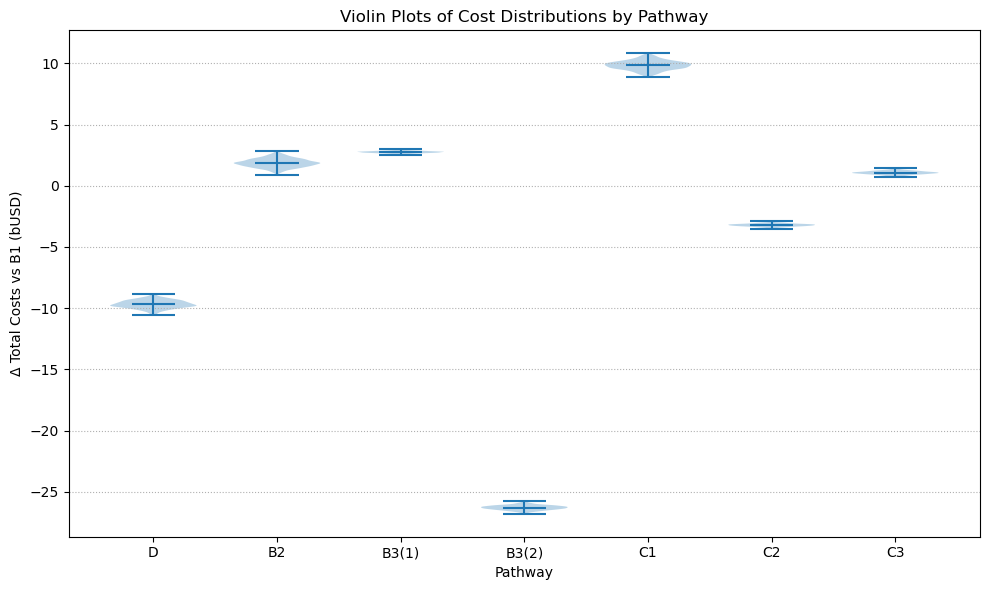


Pairwise KS-test & Wasserstein distances:
   pathway_1 pathway_2   ks_stat  ks_pvalue  wasserstein
0          D        B2  1.000000        0.0    11.539507
1          D     B3(1)  1.000000        0.0    12.428249
2          D     B3(2)  1.000000        0.0    16.608201
3          D        C1  1.000000        0.0    19.517588
4          D        C2  1.000000        0.0     6.465838
5          D        C3  1.000000        0.0    10.738512
6         B2     B3(1)  0.967611        0.0     0.888742
7         B2     B3(2)  1.000000        0.0    28.147708
8         B2        C1  1.000000        0.0     7.978081
9         B2        C2  1.000000        0.0     5.073670
10        B2        C3  0.922995        0.0     0.800995
11     B3(1)     B3(2)  1.000000        0.0    29.036450
12     B3(1)        C1  1.000000        0.0     7.089339
13     B3(1)        C2  1.000000        0.0     5.962411
14     B3(1)        C3  1.000000        0.0     1.689737
15     B3(2)        C1  1.000000        0.0  

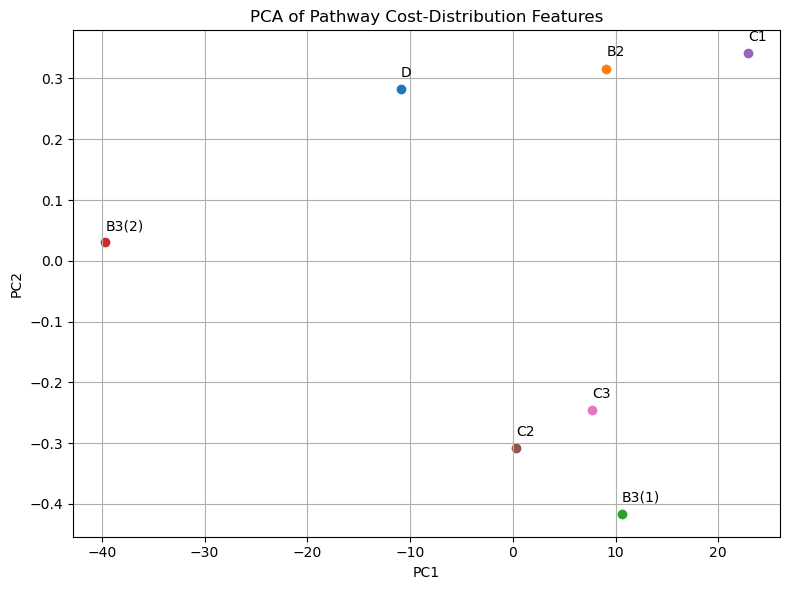

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 1) Load & clean data ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3    = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df       = pd.read_csv(file3)
df       = df[~df['Pathway'].isin(['A','B1'])]

# Remove outliers by IQR (as before)
col = 'B1_Diff_mean_bUSD'
q1  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x, 25))
q3  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x, 75))
iqr = q3 - q1
df   = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# Define pathways
pathways = sorted(df['Pathway'].unique(), key=lambda x: (x!='D', x))

# --- 2) Violin plot of each distribution ---
data_list = [df[df['Pathway']==pw][col].values for pw in pathways]

plt.figure(figsize=(10, 6))
parts = plt.violinplot(data_list,
                       positions=range(len(pathways)),
                       widths=0.7,
                       showmeans=True,
                       showextrema=True)
plt.xticks(range(len(pathways)), pathways)
plt.xlabel('Pathway')
plt.ylabel('Δ Total Costs vs B1 (bUSD)')
plt.title('Violin Plots of Cost Distributions by Pathway')
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()


# --- 3) Pairwise KS-test & Wasserstein distance ---
results = []
for i, pw1 in enumerate(pathways):
    for pw2 in pathways[i+1:]:
        data1 = df[df['Pathway']==pw1][col]
        data2 = df[df['Pathway']==pw2][col]
        ks_stat, ks_p = ks_2samp(data1, data2)
        wd = wasserstein_distance(data1, data2)
        results.append({
            'pathway_1': pw1,
            'pathway_2': pw2,
            'ks_stat':    ks_stat,
            'ks_pvalue':  ks_p,
            'wasserstein':wd
        })

ks_wd_df = pd.DataFrame(results)
print("\nPairwise KS-test & Wasserstein distances:")
print(ks_wd_df)


# --- 4) Extract distribution features per pathway ---
features = []
for pw in pathways:
    s = df[df['Pathway']==pw][col]
    features.append({
        'Pathway': pw,
        'mean':    s.mean(),
        'std':     s.std(ddof=0),
        'skew':    s.skew(),
        'kurtosis':s.kurtosis(),
        'p05':     s.quantile(0.05),
        'p95':     s.quantile(0.95)
    })

feat_df = pd.DataFrame(features).set_index('Pathway')
print("\nDistribution features:")
print(feat_df)


# --- 5) k-Means clustering on those features ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
feat_df['cluster'] = kmeans.fit_predict(feat_df)
print(f"\nAssigned clusters (k={n_clusters}):")
print(feat_df['cluster'])


# --- 6) PCA for 2-D embedding of pathways ---
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_df.drop('cluster', axis=1))

plt.figure(figsize=(8, 6))
for (pw, (x, y), c) in zip(feat_df.index, coords, feat_df['cluster']):
    plt.scatter(x, y, label=f"{pw} (clust {c})")
    plt.text(x+0.02, y+0.02, pw)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Pathway Cost-Distribution Features')
plt.grid(True)
plt.tight_layout()
plt.show()


Detected cost-item columns: ['CAPEX_mean_bUSD', 'FOM_mean_bUSD', 'VOM_mean_bUSD', 'Fuel_mean_bUSD', 'Imports_mean_bUSD', 'GHG_mean_bUSD', 'Air_emissions_mean_bUSD', 'Unmet_demand_mean_bUSD', 'CAN_Imports_adj_mean_bUSD', 'CAN_CAPEX_mean_bUSD', 'CAN_FOM_mean_bUSD', 'CAN_CH4_mean_bUSD']
Using cost items: ['CAPEX', 'FOM', 'VOM', 'Fuel', 'Imports', 'GHG', 'Air_emissions', 'Unmet_demand', 'CAN_Imports_adj', 'CAN_CAPEX', 'CAN_FOM', 'CAN_CH4']


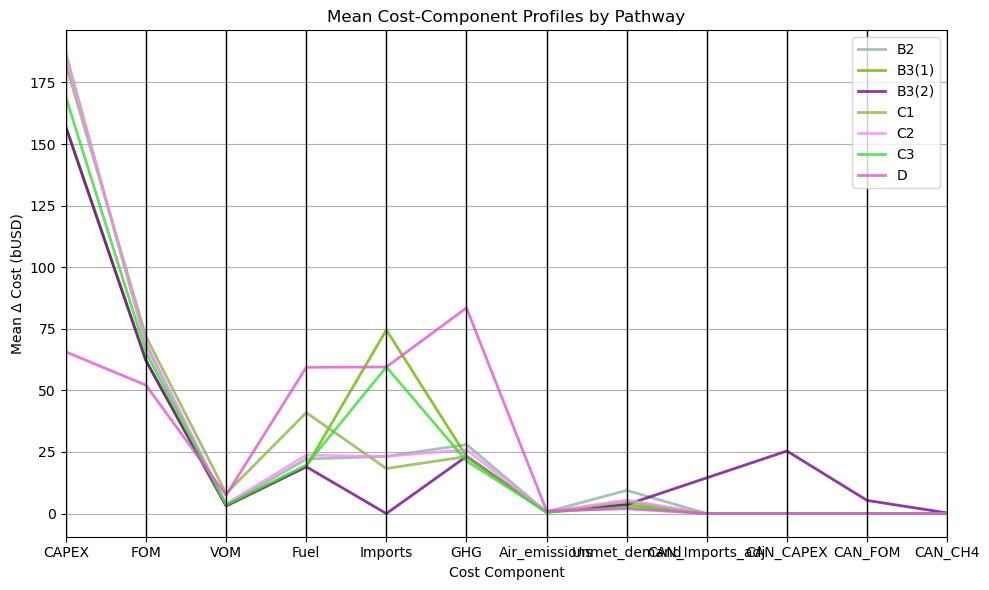

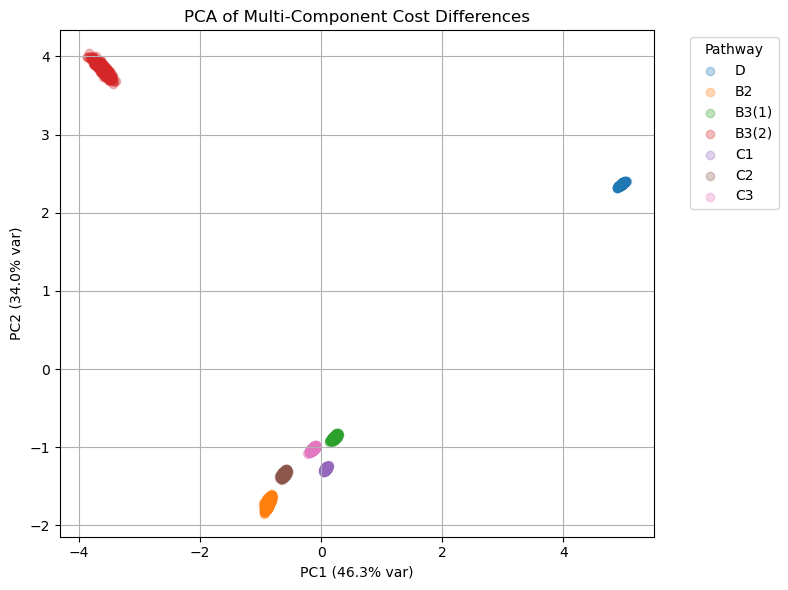

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates

# --- 1) Load & clean data (as before) ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3    = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df       = pd.read_csv(file3)
df       = df[~df['Pathway'].isin(['A','B1'])]

# (Optional) remove outliers on your aggregate column
col = 'B1_Diff_mean_bUSD'
q1  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,25))
q3  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,75))
iqr = q3 - q1
df   = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# --- 2) Auto-detect all “mean” cost item columns ---
mean_cols = [c for c in df.columns
             if c.endswith('_mean_bUSD')
             and c not in ['Total_Costs_mean_bUSD', 'B1_Diff_mean_bUSD']]

# Show what we found:
print("Detected cost-item columns:", mean_cols)

# Create a smaller DataFrame and rename columns for plotting
df_cost = df[['Pathway'] + mean_cols].copy()
# drop the “_mean_bUSD” suffix
df_cost.columns = ['Pathway'] + [c.replace('_mean_bUSD','') for c in mean_cols]
cost_items = df_cost.columns.drop('Pathway').tolist()
print("Using cost items:", cost_items)

# --- 3) Parallel-coordinates of pathway means ---
mean_profiles = df_cost.groupby('Pathway')[cost_items].mean().reset_index()

plt.figure(figsize=(10, 6))
parallel_coordinates(mean_profiles, 'Pathway', alpha=0.8, linewidth=2)
plt.title('Mean Cost-Component Profiles by Pathway')
plt.ylabel('Mean Δ Cost (bUSD)')
plt.xlabel('Cost Component')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4) PCA on the full simulation-level cost vectors ---
X = df_cost[cost_items].values
y = df_cost['Pathway'].values

# standardize each cost item
Xs = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(Xs)
df_cost['PC1'], df_cost['PC2'] = pcs[:,0], pcs[:,1]

plt.figure(figsize=(8, 6))
for pw in sorted(df_cost['Pathway'].unique(), key=lambda x:(x!='D', x)):
    sub = df_cost[df_cost['Pathway']==pw]
    plt.scatter(sub['PC1'], sub['PC2'], alpha=0.3, label=pw)

plt.legend(title='Pathway', bbox_to_anchor=(1.05,1), loc='upper left')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title('PCA of Multi-Component Cost Differences')
plt.grid(True)
plt.tight_layout()
plt.show()


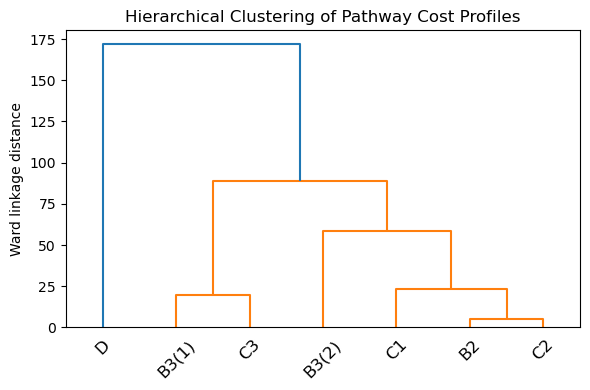

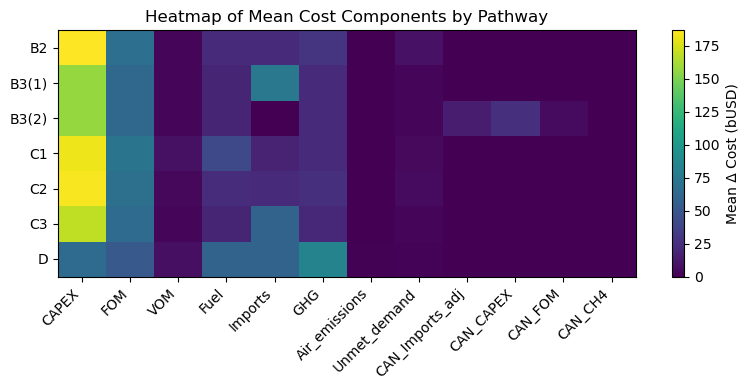

RF classification accuracy: 1.00


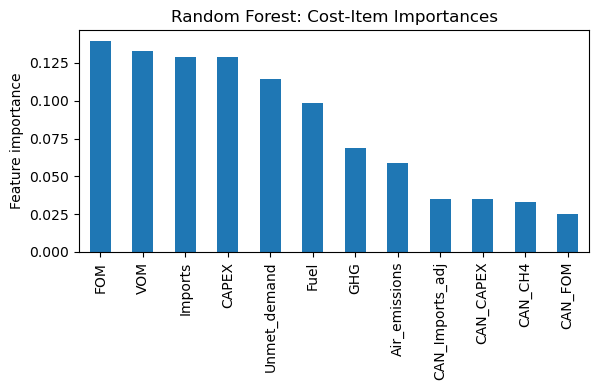

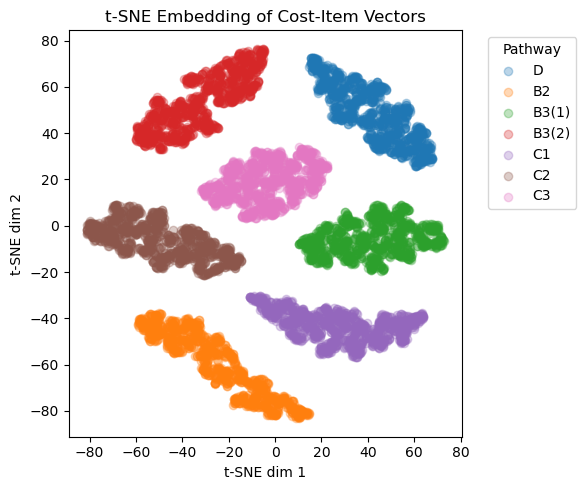

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# --- 1) Load & clean & detect cost‐items (as before) ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3    = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df       = pd.read_csv(file3)
df       = df[~df['Pathway'].isin(['A','B1'])]

# optional outlier removal on B1_Diff
col = 'B1_Diff_mean_bUSD'
q1  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,25))
q3  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,75))
iqr = q3 - q1
df   = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# auto‐detect mean‐cost columns
mean_cols = [c for c in df.columns if c.endswith('_mean_bUSD')
             and c not in ['Total_Costs_mean_bUSD','B1_Diff_mean_bUSD']]
df_cost = df[['Pathway'] + mean_cols].copy()
df_cost.columns = ['Pathway'] + [c.replace('_mean_bUSD','') for c in mean_cols]
cost_items = df_cost.columns.drop('Pathway').tolist()

# standardize features
X = StandardScaler().fit_transform(df_cost[cost_items])
y = df_cost['Pathway']

# --- 2) Hierarchical clustering of pathway‐mean profiles ---
mean_profiles = df_cost.groupby('Pathway')[cost_items].mean()
link = linkage(mean_profiles, method='ward')  # you can try 'single','complete','average'

plt.figure(figsize=(6,4))
dendrogram(link, labels=mean_profiles.index, leaf_rotation=45)
plt.title('Hierarchical Clustering of Pathway Cost Profiles')
plt.ylabel('Ward linkage distance')
plt.tight_layout()
plt.show()

# --- 3) Heatmap of mean cost‐item by pathway ---
plt.figure(figsize=(8,4))
plt.imshow(mean_profiles.values, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Mean Δ Cost (bUSD)')
plt.yticks(np.arange(len(mean_profiles)), mean_profiles.index)
plt.xticks(np.arange(len(cost_items)), cost_items, rotation=45, ha='right')
plt.title('Heatmap of Mean Cost Components by Pathway')
plt.tight_layout()
plt.show()

# --- 4) Random Forest: how well cost‐items predict Pathway & feature importances ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"RF classification accuracy: {accuracy_score(y_test, y_pred):.2f}")

importances = pd.Series(rf.feature_importances_, index=cost_items).sort_values(ascending=False)
plt.figure(figsize=(6,4))
importances.plot.bar()
plt.ylabel('Feature importance')
plt.title('Random Forest: Cost‐Item Importances')
plt.tight_layout()
plt.show()

# --- 5) t-SNE 2D embedding of simulation‐level cost profiles ---
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
Z = tsne.fit_transform(X)
df_cost['TSNE1'], df_cost['TSNE2'] = Z[:,0], Z[:,1]

plt.figure(figsize=(6,5))
for pw in sorted(df_cost['Pathway'].unique(), key=lambda x:(x!='D',x)):
    sub = df_cost[df_cost['Pathway']==pw]
    plt.scatter(sub['TSNE1'], sub['TSNE2'], alpha=0.3, label=pw)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title='Pathway')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')
plt.title('t-SNE Embedding of Cost‐Item Vectors')
plt.tight_layout()
plt.show()


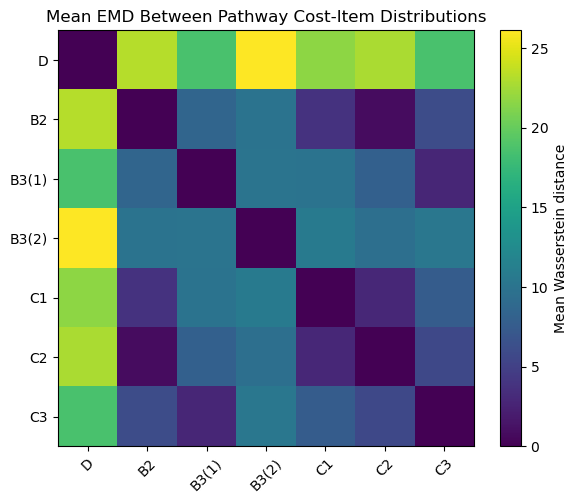

In [54]:
from scipy.stats import wasserstein_distance

# compute pathway-to-pathway distance matrix
pw_vals = {pw: df_cost[df_cost['Pathway']==pw][cost_items].values for pw in pathways}
dist_mat = np.zeros((len(pathways), len(pathways)))

for i, a in enumerate(pathways):
    for j, b in enumerate(pathways):
        # average pairwise EMD over each cost dimension
        dist_mat[i,j] = np.mean([
            wasserstein_distance(pw_vals[a][:,k], pw_vals[b][:,k])
            for k in range(len(cost_items))
        ])

plt.figure(figsize=(6,5))
im = plt.imshow(dist_mat, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label='Mean Wasserstein distance')
plt.xticks(range(len(pathways)), pathways, rotation=45)
plt.yticks(range(len(pathways)), pathways)
plt.title("Mean EMD Between Pathway Cost-Item Distributions")
plt.tight_layout()
plt.show()


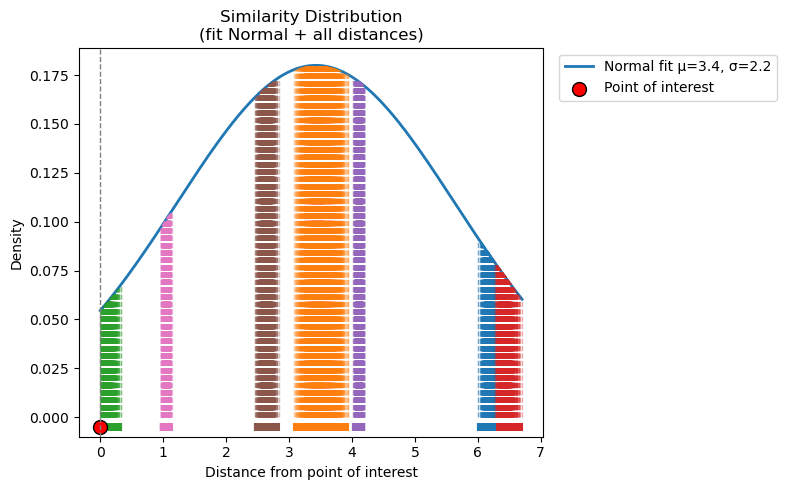

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# --- 1) Load & clean & pick up mean‐cost columns (as before) ---
base_dir = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final"
file3    = os.path.join(base_dir, "discount rate 2 percent/All_Costs_per_Simulation.csv")
df       = pd.read_csv(file3)
df       = df[~df['Pathway'].isin(['A','B1'])]

# (Optional) IQR‐based outlier removal on your aggregate column
col = 'B1_Diff_mean_bUSD'
q1  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,25))
q3  = df.groupby('Pathway')[col].transform(lambda x: np.percentile(x,75))
iqr = q3 - q1
df   = df[df[col].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]

# auto‐detect all per‐sim “mean” cost items, drop totals/diffs
mean_cols = [c for c in df.columns if c.endswith('_mean_bUSD') 
             and c not in ['Total_Costs_mean_bUSD','B1_Diff_mean_bUSD']]
df_cost = df[['Pathway'] + mean_cols].copy()
df_cost.columns = ['Pathway'] + [c.replace('_mean_bUSD','') for c in mean_cols]
cost_items = df_cost.columns.drop('Pathway').tolist()

# --- 2) Build standardized feature matrix & choose POI ---
X   = df_cost[cost_items].values
Xs  = StandardScaler().fit_transform(X)

# pick one simulation (e.g. first “D”) as the point‐of‐interest
poi_idx = df_cost[df_cost['Pathway']=='D'].index[0]
poi     = Xs[poi_idx]

# --- 3) Compute distances & fit Normal ---
dists      = np.linalg.norm(Xs - poi, axis=1)
mu, sigma  = norm.fit(dists)
x_grid     = np.linspace(dists.min(), dists.max(), 300)
pdf_vals   = norm.pdf(x_grid, mu, sigma)

# --- 4) Prepare colors ---
pathways = sorted(df_cost['Pathway'].unique(), key=lambda x:(x!='D',x))
tab10    = plt.get_cmap('tab10')
cmap     = {pw: tab10(i) for i,pw in enumerate(pathways)}

# --- 5) Make the plot ---
plt.figure(figsize=(8,5))

# 5a) The Normal PDF curve
plt.plot(x_grid, pdf_vals, color='C0', lw=2,
         label=f'Normal fit μ={mu:.1f}, σ={sigma:.1f}')

# 5b) For each simulation: a dashed line from y=0 up to PDF(distance)
for xi, pw in zip(dists, df_cost['Pathway']):
    yi = norm.pdf(xi, mu, sigma)
    plt.vlines(xi, 0, yi,
               color=cmap[pw], alpha=0.4, linestyle='--', linewidth=1)

# 5c) A little “rug” of ticks (dots) at y = –0.005 to show each point
baseline = -0.005
plt.scatter(dists, np.full_like(dists, baseline),
            c=[cmap[p] for p in df_cost['Pathway']],
            s=30, marker='|', linewidth=1.5)

# 5d) Highlight the POI at distance = 0
plt.scatter(0, baseline, color='red', s=100, edgecolor='k', label='Point of interest')

# 5e) Styling
plt.axvline(0, linestyle='--', color='gray', lw=1)
plt.ylim(baseline - 0.005, pdf_vals.max() * 1.05)
plt.xlabel('Distance from point of interest')
plt.ylabel('Density')
plt.title('Similarity Distribution\n(fit Normal + all distances)')
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()
